In [20]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY') 
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [21]:
profile = {
    "name": "Sarah",
    "full_name": "Sarah Chen",
    "user_profile_background": "Engenheira de software sênior liderando uma equipe de 5 desenvolvedores",
}

In [22]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Newsletters de marketing, e-mails de spam, comunicados gerais da empresa",
        "notify": "Membro da equipe doente, notificações do sistema de build, atualizações de status de projeto",
        "respond": "Perguntas diretas de membros da equipe, solicitações de reunião, relatórios de bugs críticos",
    },
    "agent_instructions": "Use estas ferramentas quando apropriado para ajudar a gerenciar as tarefas de Sarah de forma eficiente."
}

In [23]:
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "Sarah Chen <sarah.chen@company.com>",
    "subject": "Dúvida rápida sobre a documentação da API",
    "body": """
Olá Sarah,

Eu estava revisando a documentação da API para o novo serviço de autenticação e notei que alguns endpoints parecem estar faltando nas especificações. Você poderia me ajudar a esclarecer se isso foi intencional ou se devemos atualizar a documentação?

Especificamente, estou procurando por:
- /auth/refresh
- - /auth/validate

Obrigada!
Alice""",
}

In [24]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [25]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-5-nano-2025-08-07")

In [26]:
class Router(BaseModel): 
    """Analisa o e-mail não lido e o roteia de acordo com seu conteúdo."""

    reasoning: str = Field(
        description="Raciocínio passo a passo por trás da classificação."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="A classificação de um e-mail: 'ignore' para e-mails irrelevantes, "
        "'notify' para informações importantes que não precisam de resposta, "
        "'respond' para e-mails que precisam de uma resposta",
    )

In [27]:
llm_router = llm.with_structured_output(Router)

In [28]:
from prompts import triage_system_prompt, triage_user_prompt

In [29]:
system_prompt = triage_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [30]:
user_prompt = triage_user_prompt.format(
    author=email["from"],
    to=email["to"],
    subject=email["subject"],
    email_thread=email["body"],
)

In [31]:
result = llm_router.invoke(
    [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
)

In [32]:
print(result)

reasoning="A mensagem é direta de uma membro da equipe solicitando esclarecimentos sobre a documentação da API, especificamente se determinados endpoints devem estar documentados (/auth/refresh e /auth/validate). Não é spam/marketing e não é apenas uma notificação; requer uma resposta direta de Sarah para confirmar o estado dos endpoints e possivelmente atualizar a documentação. Classifica-se como 'respond'. Recomenda-se que Sarah responda com: (1) confirmar se esses endpoints existem/estão planejados; (2) indicar se estão apenas em desenvolvimento; (3) informar onde a documentação atual está ou fornecer um link; (4) se necessário, criar uma tarefa de atualização da documentação com responsáveis e prazo." classification='respond'


In [33]:
from langchain_core.tools import tool

In [34]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Escreve e envia um e-mail."""
    # Resposta de placeholder - em um aplicativo real, enviaria o e-mail
    return f"E-mail enviado para {to} com o assunto '{subject}'"

In [35]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Agenda uma reunião no calendário."""

    return f"Reunião '{subject}' agendada para {preferred_day} com {len(attendees)} participantes"

In [36]:
@tool
def check_calendar_availability(day: str) -> str:
    """Verifica a disponibilidade do calendário para um determinado dia."""

    return f"Horários disponíveis em {day}: 9:00 AM, 2:00 PM, 4:00 PM"

In [37]:
from prompts import agent_system_prompt

def create_prompt(state):
    return [
        {
            "role": "system",
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
            )
        }
    ] + state['messages']

In [38]:
print(agent_system_prompt)


< Função >
Você é o(a) assistente executivo(a) de {full_name}. Você é um(a) assistente executivo(a) de alto nível que se preocupa com o desempenho de {name} o máximo possível.
</ Função >

< Ferramentas >
Você tem acesso às seguintes ferramentas para ajudar a gerenciar as comunicações e a agenda de {name}:

1. write_email(to, subject, content) - Envia e-mails para destinatários especificados
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Agenda reuniões no calendário
3. check_calendar_availability(day) - Verifica os horários disponíveis em um determinado dia
</ Ferramentas >

< Instruções >
{instructions}
</ Instruções >



In [39]:
from langgraph.prebuilt import create_react_agent

In [40]:
tools=[write_email, schedule_meeting, check_calendar_availability]

In [41]:
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-5-nano-2025-08-07")

agent = create_react_agent(
    model=llm,  
    tools=tools,
    prompt=create_prompt,
)

C:\Users\rondi\AppData\Local\Temp\ipykernel_27012\892751838.py:5: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


In [ ]:
response = agent.invoke(
    {"messages": [{
        "role": "user",
        "content": "qual é minha disponibilidade para terça-feira?"
    }]}
)

In [43]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Para terça-feira, 2 de dezembro de 2025, os horários disponíveis são:
- 9:00
- 14:00 (2:00 PM)
- 16:00 (4:00 PM)

Deseja que eu agende uma reunião em algum desses horários? Se sim, me passe:
- duração (ex.: 30, 45 ou 60 minutos)
- assunto/título do encontro
- participantes (e-mails)
- local/sala ou chamada (se aplicável)

Posso também sugerir marcar 30 minutos às 9:00 ou 14:00, se quiser.


In [ ]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [46]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classificação: RESPONDER - Este e-mail requer uma resposta")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Responda ao e-mail {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classificação: IGNORAR - Este e-mail pode ser ignorado com segurança")
        update = None
        goto = END
    elif result.classification == "notify":
        # Em um cenário real, isso faria outra coisa
        print("🔔 Classificação: NOTIFICAR - Este e-mail contém informações importantes")
        update = None
        goto = END
    else:
        raise ValueError(f"Classificação inválida: {result.classification}")
    return Command(goto=goto, update=update)

In [47]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node("triage_router", triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile()

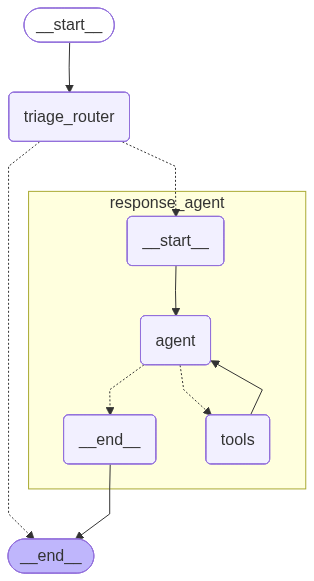

In [48]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [49]:
email_input = {
    "author": "Equipe de Marketing <marketing@amazingdeals.com>",
    "to": "Sarah Chen <sarah.chen@company.com>",
    "subject": "🔥 OFERTA EXCLUSIVA: Desconto por Tempo Limitado em Ferramentas para Desenvolvedores! 🔥",
    "email_thread": """Prezado(a) Desenvolvedor(a),

Não perca esta oportunidade INCRÍVEL! 

🚀 POR TEMPO LIMITADO, obtenha 80% DE DESCONTO em nosso Pacote Premium para Desenvolvedores! 

✨ RECURSOS:
- Preenchimento de código revolucionário com IA
- Ambiente de desenvolvimento baseado em nuvem
- Suporte ao cliente 24/7
- E muito mais!

💰 Preço Normal: R$ 999/mês
🎉 SEU PREÇO ESPECIAL: Apenas R$ 199/mês!

🕒 Corra! Esta oferta expira em:
APENAS 24 HORAS!

Clique aqui para resgatar seu desconto: https://amazingdeals.com/special-offer

Atenciosamente,
Equipe de Marketing
---
Para cancelar a inscrição, clique aqui
""",
}

In [50]:
response = email_agent.invoke({"email_input": email_input})

🚫 Classificação: IGNORAR - Este e-mail pode ser ignorado com segurança


In [51]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "Sarah Chen <sarah.chen@company.com>",
    "subject": "Dúvida rápida sobre a documentação da API",
    "email_thread": """Olá Sarah,

Eu estava revisando a documentação da API para o novo serviço de autenticação e notei que alguns endpoints parecem estar faltando nas especificações. Você poderia me ajudar a esclarecer se isso foi intencional ou se devemos atualizar a documentação?

Especificamente, estou procurando por:
- /auth/refresh
- /auth/validate

Obrigada!
Alice""",
}

In [52]:
response = email_agent.invoke({"email_input": email_input})

📧 Classificação: RESPONDER - Este e-mail requer uma resposta


In [53]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Responda ao e-mail {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Sarah Chen <sarah.chen@company.com>', 'subject': 'Dúvida rápida sobre a documentação da API', 'email_thread': 'Olá Sarah,\n\nEu estava revisando a documentação da API para o novo serviço de autenticação e notei que alguns endpoints parecem estar faltando nas especificações. Você poderia me ajudar a esclarecer se isso foi intencional ou se devemos atualizar a documentação?\n\nEspecificamente, estou procurando por:\n- /auth/refresh\n- /auth/validate\n\nObrigada!\nAlice'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_R4ZG0o3AMSGTv02ifIrhcZMk)
 Call ID: call_R4ZG0o3AMSGTv02ifIrhcZMk
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Dúvida rápida sobre a documentação da API
    content: Olá Alice,

Obrigado pelo toque. Estou verificando com a equi